In [ ]:
# Parquet files to analyze
filenames = [
    # "ldmc_hiba",
    "ldmc_vera",
    # "sla_hiba",
    # "sla_vera",
]

AGGREGATION_KEY = "ID"
WORKSPACE_PATH = "workspace"
CHARTS_OUTPUT_DIR = "charts"


EXCLUDE_MODELS = ["KernelPLS", "Sequential", "NICON"]
MODEL_RENAME_MAP = {
    "tabpfn": "transformer",
    "tabpfn-real": "transformer-2",
}

workspace/ldmc_vera.meta.parquet

 Loaded 240 predictions from ldmc_vera
   Excluded 15 predictions matching: ['KernelPLS', 'Sequential', 'NICON']
   Stripped suffixes from model names: ['TabPFNRegressor']
   Renamed 135 predictions matching 'tabpfn'  'transformer'
   Using 225 predictions after filtering
   Task type: Regression

 Top 5 models for ldmc_vera:
  1. transformer: rmse=4.8742
  2. transformer: rmse=4.9266
  3. transformer: rmse=4.9498
  4. transformer: rmse=4.9830
  5. transformer: rmse=4.9833

=== Charts for ldmc_vera ===

Top-K comparisons:

Top-3 models (ranked by val):
   Saved: charts/ldmc_vera_top3_test_rank_val.png

Top-3 models (ranked by test):
   Saved: charts/ldmc_vera_top3_test_rank_test.png


NameError: name 'AGGREGATION_KEY' is not defined

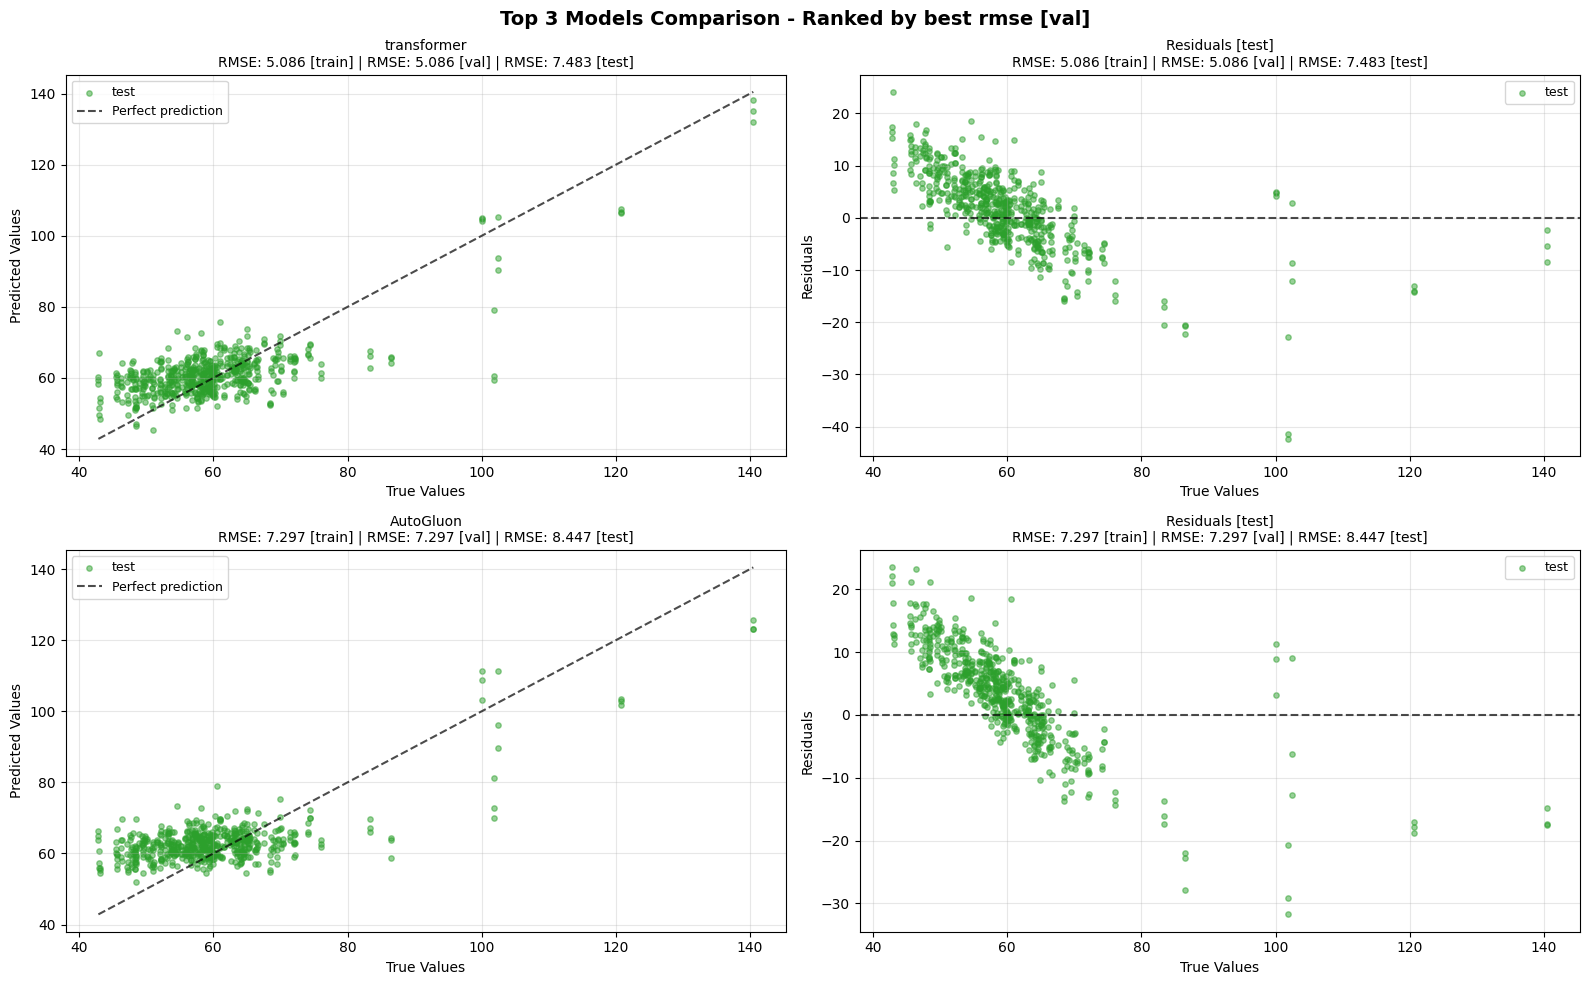

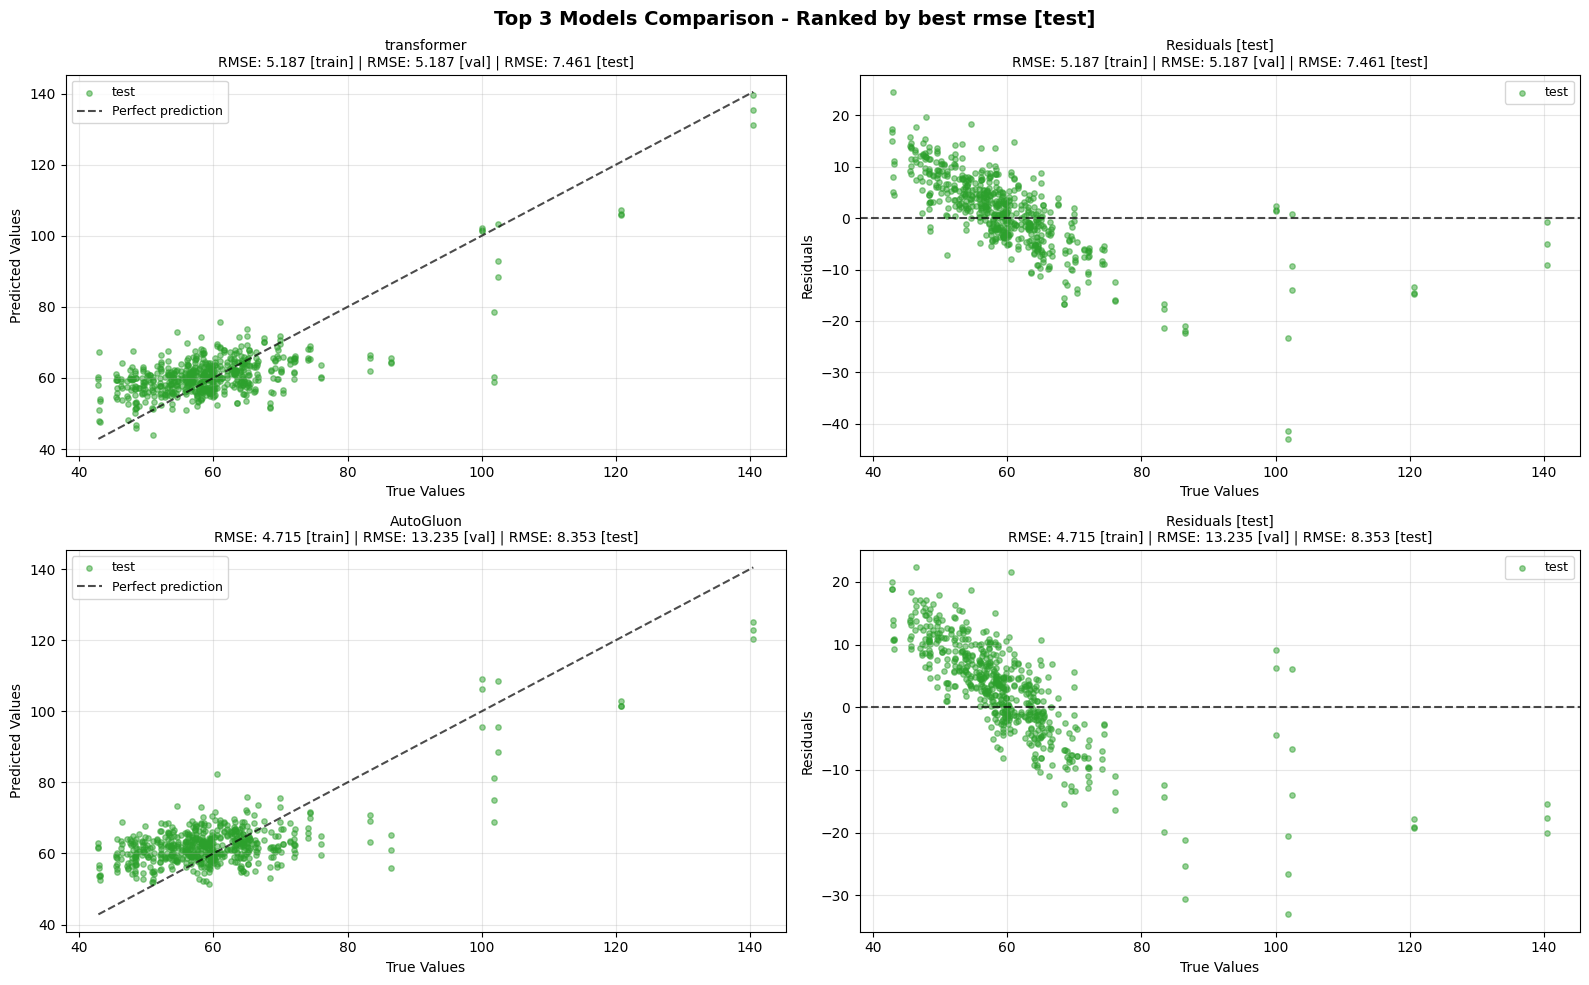

In [3]:
from pathlib import Path
import matplotlib.pyplot as plt
import polars as pl
import re
from nirs4all.data import Predictions
from nirs4all.visualization.predictions import PredictionAnalyzer


def apply_model_filters(predictions: Predictions, exclude_models: list, rename_map: dict, strip_suffixes: list = None) -> Predictions:
    if strip_suffixes is None:
        strip_suffixes = ["classifier", "regressor"]

    df = predictions._storage._df
    original_count = len(df)

    # Exclude models (case-insensitive partial match)
    if exclude_models:
        # Build case-insensitive pattern for exclusion
        exclude_pattern = '(?i)(' + '|'.join(re.escape(m) for m in exclude_models) + ')'
        df = df.filter(~pl.col("model_classname").str.contains(exclude_pattern))
        df = df.filter(~pl.col("model_name").str.contains(exclude_pattern))
        excluded_count = original_count - len(df)
        if excluded_count > 0:
            print(f"  🚫 Excluded {excluded_count} predictions matching: {exclude_models}")

    # Strip suffixes first (case-insensitive)
    if strip_suffixes:
        # Build regex pattern for case-insensitive suffix removal
        suffix_pattern = '(?i)(' + '|'.join(re.escape(s) for s in strip_suffixes) + ')$'

        # Get unique model names before stripping
        unique_before = set(df["model_classname"].unique().to_list())

        # Apply suffix stripping to both model_classname and model_name
        df = df.with_columns([
            pl.col("model_classname").str.replace(suffix_pattern, "").alias("model_classname"),
            pl.col("model_name").str.replace(suffix_pattern, "").alias("model_name"),
        ])

        # Get unique model names after stripping
        unique_after = set(df["model_classname"].unique().to_list())

        # Report changes
        changed = unique_before - unique_after
        if changed:
            print(f"  ✂️ Stripped suffixes from model names: {sorted(changed)}")

    # Rename models using rename_map (case-insensitive partial match)
    if rename_map:
        for old_pattern, new_name in rename_map.items():
            # Case-insensitive pattern
            pattern = f'(?i){re.escape(old_pattern)}'

            # Count matches before rename
            match_count = df.filter(pl.col("model_classname").str.contains(pattern)).height

            if match_count > 0:
                # Replace the pattern with new_name (replaces entire string, not just pattern)
                # We want to replace the whole model name, not just the matching part
                df = df.with_columns([
                    pl.when(pl.col("model_classname").str.contains(pattern))
                    .then(pl.lit(new_name))
                    .otherwise(pl.col("model_classname"))
                    .alias("model_classname"),
                    pl.when(pl.col("model_name").str.contains(pattern))
                    .then(pl.lit(new_name))
                    .otherwise(pl.col("model_name"))
                    .alias("model_name"),
                ])
                print(f"  ✏️ Renamed {match_count} predictions matching '{old_pattern}' → '{new_name}'")

    predictions._storage._df = df
    return predictions

def save_figure(fig, name):
    """Save figure to charts output directory with multiple formats."""
    output_dir = Path(CHARTS_OUTPUT_DIR)
    output_dir.mkdir(exist_ok=True)

    for fmt in ['png']:
        path = output_dir / f"{filename}_{name}.{fmt}"
        fig.savefig(path, dpi=150, bbox_inches='tight')
        print(f"  📁 Saved: {path}")

for filename in filenames:
    predictions_path = f"{WORKSPACE_PATH}/{filename}.meta.parquet"
    print(predictions_path)
    # Load predictions
    predictions = Predictions.load(path=predictions_path)
    print(f"\n📂 Loaded {len(predictions)} predictions from {filename}")

    # Skip empty prediction files
    if len(predictions) == 0:
        print(f"  ⚠️ Skipping {filename} - no predictions found")
        continue

    # Apply model filtering and renaming
    predictions = apply_model_filters(predictions, EXCLUDE_MODELS, MODEL_RENAME_MAP)
    print(f"  ➡️ Using {len(predictions)} predictions after filtering")

    # Create analyzer - output_dir=None to disable auto-saving (we save manually with titles)
    analyzer = PredictionAnalyzer(
        predictions,
        output_dir=None,  # Disable internal auto-save to avoid duplicates
    )

    # Get the dataset name and determine the metric type
    datasets = predictions.get_datasets()
    dataset_name = datasets[0] if datasets else filename
    file_name = Path(filename).stem

    # Detect if classification or regression based on task_type stored in predictions
    task_types = predictions.get_unique_values('task_type')
    is_classification = any(t and 'classification' in str(t).lower() for t in task_types)

    if is_classification:
        # Use classification metrics
        rank_metric = 'balanced_accuracy'
        display_metrics = ['balanced_accuracy', 'accuracy', 'f1']
        print(f"  📋 Task type: Classification")
    else:
        # Use regression metrics
        rank_metric = 'rmse'
        display_metrics = ['rmse', 'r2', 'mape', 'nrmse']
        print(f"  📋 Task type: Regression")

    # Show top models
    print(f"\n📊 Top 5 models for {file_name}:")
    top_models = predictions.top(n=5, rank_metric=rank_metric, rank_partition='val', aggregate="ID")
    for i, model in enumerate(top_models, 1):
        # rank_score is stored at top level of PredictionResult after aggregation
        score = model.get('rank_score', 'N/A')
        model_name = model.get('model_name', 'Unknown')
        if isinstance(score, (int, float)):
            print(f"  {i}. {model_name}: {rank_metric}={score:.4f}")
        else:
            print(f"  {i}. {model_name}: {rank_metric}={score}")

    # Common heatmap config
    hm_config = {
        # 'fig_fontsize': 20,      # Default font size
        # 'title_fontsize': 24,     # Figure titles
        # 'legend_fontsize': 12,    # Legend text
        # 'axis_fontsize': 20,      # Axis labels
        # 'tick_fontsize': 16,      # Axis tick labels
        'annotation_fontsize': 18    # Text inside charts (heatmap cells, etc.)
    }

    # ============================
    # CHARTS
    # ============================
    print(f"\n=== Charts for {file_name} ===")

    # --- Confusion matrix (only for classification) ---
    if is_classification:
        print(f"\nConfusion matrices:")

        def confusion_matrix(rank_partition='val', aggregate=None):
            print(f"\nConfusion matrix (ranked by {rank_partition}):")
            fig_cm = analyzer.plot_confusion_matrix(
                rank_metric=rank_metric,
                display_metric=rank_metric,
                display_partition='test',
                rank_partition=rank_partition,
                aggregate=aggregate
            )
            agg_suffix = f"_agg_{AGGREGATION_KEY}" if aggregate else ""
            save_figure(fig_cm, f"confusion_matrix_{rank_partition}{agg_suffix}")

        confusion_matrix(rank_partition='test')
        confusion_matrix(rank_partition='val')
        if AGGREGATION_KEY != None:
            confusion_matrix(rank_partition='test', aggregate=AGGREGATION_KEY)
            confusion_matrix(rank_partition='val', aggregate=AGGREGATION_KEY)

    # --- Top-K comparison (only for regression - scatter plots) ---
    if not is_classification:
        print(f"\nTop-K comparisons:")

        def top_k_comparison(rank_partition='val', aggregate=None):
            print(f"\nTop-3 models (ranked by {rank_partition}):")
            fig_top3 = analyzer.plot_top_k(
                k=3,
                rank_metric=rank_metric,
                rank_partition=rank_partition,
                display_partition='test',
                aggregate=aggregate
            )
            agg_suffix = f"_agg_{AGGREGATION_KEY}" if aggregate else ""
            save_figure(fig_top3, f"top3_test_rank_{rank_partition}{agg_suffix}")

        top_k_comparison(rank_partition='val')
        top_k_comparison(rank_partition='test')
        if AGGREGATION_KEY != None:
            top_k_comparison(rank_partition='val', aggregate=AGGREGATION_KEY)
            top_k_comparison(rank_partition='test', aggregate=AGGREGATION_KEY)

    # --- Heatmaps ---
    print(f"\n📊 Heatmaps:")

    def heatmap(rank_partition='val', aggregate=None, top_k=20):
        print(f"\nHeatmap (ranked by {rank_partition}):")
        fig_heatmap = analyzer.plot_heatmap(
            x_var="partition",
            y_var="model_name",
            rank_metric=rank_metric,
            display_metric=rank_metric,
            show_counts=False,
            rank_partition=rank_partition,
            aggregate=aggregate,
            column_scale = True,
            top_k=top_k,
            sort_by='value',
            config=hm_config
        )
        agg_suffix = f"_agg_{AGGREGATION_KEY}" if aggregate else ""
        save_figure(fig_heatmap, f"heatmap_{rank_metric}_rank_{rank_partition}{agg_suffix}")

    heatmap(rank_partition='val', top_k=20)
    heatmap(rank_partition='test', top_k=8)
    if AGGREGATION_KEY != None:
        heatmap(rank_partition='val', aggregate=AGGREGATION_KEY, top_k=20)
        heatmap(rank_partition='test', aggregate=AGGREGATION_KEY, top_k=8)

    # --- Candlestick plots ---
    print(f"\n📊 Candlestick plots:")
    def candlestick(rank_partition='val', aggregate=None):
        print(f"\nCandlestick plot (ranked by {rank_partition}):")
        fig_candlestick = analyzer.plot_candlestick(
            variable="model_name",
            display_metric=rank_metric,
            display_partition='test',
            aggregate=aggregate
        )
        agg_suffix = f"_agg_{AGGREGATION_KEY}" if aggregate else ""
        save_figure(fig_candlestick, f"candlestick_{rank_metric}_test{agg_suffix}")

    candlestick(rank_partition='val')
    candlestick(rank_partition='test')
    if AGGREGATION_KEY != None:
        candlestick(rank_partition='val', aggregate=AGGREGATION_KEY)
        candlestick(rank_partition='test', aggregate=AGGREGATION_KEY)

    # --- Histograms ---
    def histogram(rank_partition='val', aggregate=None):
        print(f"\nHistogram (ranked by {rank_partition}):")
        fig_histogram = analyzer.plot_histogram(
            display_metric=rank_metric,
            display_partition='test',
            aggregate=aggregate
        )
        agg_suffix = f"_agg_{AGGREGATION_KEY}" if aggregate else ""
        save_figure(fig_histogram, f"histogram_{rank_metric}_test{agg_suffix}")

    histogram(rank_partition='val')
    histogram(rank_partition='test')
    if AGGREGATION_KEY != None:
        histogram(rank_partition='val', aggregate=AGGREGATION_KEY)
        histogram(rank_partition='test', aggregate=AGGREGATION_KEY)

    print(f"\n✅ All charts generated for {file_name}")

print("\n🎉 All datasets processed!")